# Information
- Milvus running on local host. Need to change it when placing on cloud
- Only one PDF was loaded into milvus, so need to update it


### Information on architecture built
- MILVUS STORAGE name: `medical_knowledge_base_v2`
- embedding model: `sentence-transformers/all-MiniLM-L6-v2`

# Loading PDFs

In [48]:
from pathlib import Path
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [49]:
data_directory = "/Users/brunamedeiros/Documents/University of Chicago/Spring 2025 - Capstone I/FINAL DATASET"

# Check how many PDF files you have on disk
pdf_files = list(Path(data_directory).rglob("*.pdf"))
print(f"Found {len(pdf_files)} PDF files:")
for p in pdf_files:
    print("  ", p.name)

Found 1 PDF files:
   Diagnostic Imaging Genitourinary ( PDFDrive ).pdf


In [50]:
# Load every page as a Document
loader = DirectoryLoader(data_directory, glob="**/*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()
print(f"\nLoaded {len(docs)} pages from your PDFs")

# Split
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)
print(f"\nAfter splitting, you have {len(chunks)} chunks")
print("\nSample chunk (200 chars):", chunks[0].page_content[:200])

# Sanity Check
print("\nChar count of doc[8]:", len(docs[8].page_content))
print("\nSample text:", docs[8].page_content[:500])



Loaded 641 pages from your PDFs

After splitting, you have 2240 chunks

Sample chunk (200 chars): THIRD EDITION

Char count of doc[8]: 4

Sample text: viii


# Embeddings

In [73]:
# Embed + Store in Milvus
from pymilvus import connections
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Milvus
from pymilvus import connections, utility
from pymilvus import Collection

# Visualization 
from pymilvus.orm.collection import Collection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [59]:
# Connect to Milvus
connections.disconnect("default")  # force reset
connections.connect(host="localhost", port="19530")
print(utility.list_collections())  # confirm it

[]


In [ ]:
# Initialize Hugging Face embedder
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Embed and insert into Milvus
collection_name = "medical_knowledge_base_v2"

try:
    # Try to connect to an existing Milvus collection
    vector_store = Milvus(
        embedding_function=embedder,
        collection_name=collection_name,
        connection_args={"host": "localhost", "port": "19530"}
    )
    vector_store.add_documents(chunks)
    print(f"✅ Added {len(chunks)} chunks to existing collection '{collection_name}'.")
except Exception:
    # If collection doesn't exist, create it and insert
    vector_store = Milvus.from_documents(
        documents=chunks,
        embedding=embedder,
        collection_name=collection_name,
        connection_args={"host": "localhost", "port": "19530"}
    )
    print(f"✅ Created new collection '{collection_name}' with {len(chunks)} chunks.")

✅ Created new collection 'medical_knowledge_base_v2' with 2240 chunks.


In [ ]:
# Confirm total stored vectors
collection = Collection("medical_knowledge_base_v2")
print("✅ Total vectors stored:", collection.num_entities)

✅ Total vectors stored: 2240


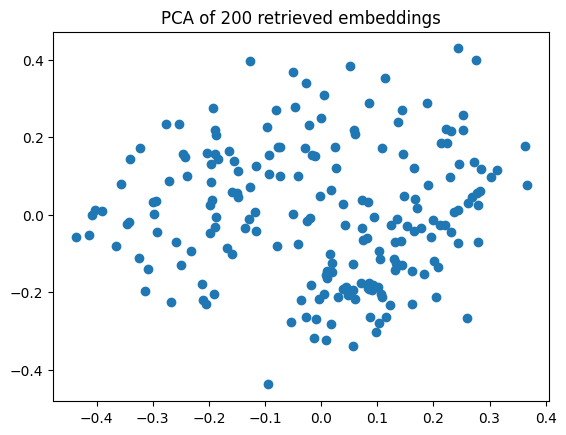

In [74]:

# 1. Reconnect to vector store
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vs = Milvus(
    embedding_function=embedder,
    collection_name="medical_knowledge_base_v2",
    connection_args={"host": "localhost", "port": "19530"},
)

# 2. Embed a dummy query and search for top 200 vectors
query = "radiology imaging of the kidney"
results = vs.similarity_search_with_score(query, k=200)

# 3. Extract embeddings (recompute them)
vecs = np.array([embedder.embed_query(doc.page_content) for doc, _ in results])

# 4. Reduce + plot
coords = PCA(n_components=2).fit_transform(vecs)
plt.scatter(coords[:, 0], coords[:, 1])
plt.title("PCA of 200 retrieved embeddings")
plt.show()
